# Identifying Entities in Healthcare Data

## Workspace set up: Import and Install useful packages.

In [1]:
# !pip install pycrf
# !pip install sklearn-crfsuite
# !pip install spacy
# !python -m spacy download en_core_web_sm
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install nltk

## NLP esssentials
import spacy
import nltk as nlp
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics
import regex as re
from IPython.display import display

## Pandas and numpy for data wrangling  and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model = spacy.load("en_core_web_sm")

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

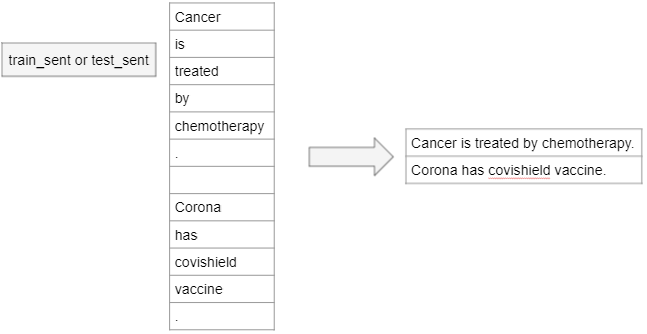

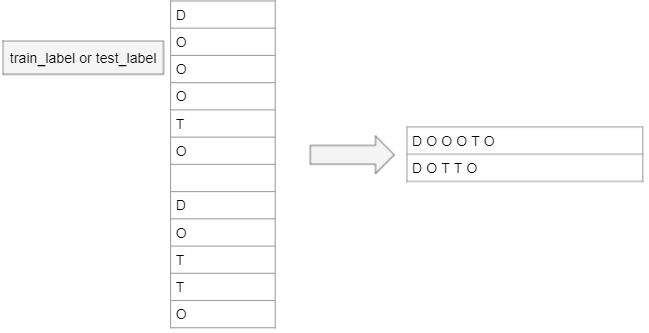

In [2]:
### Loading files
def extract_txt_from_file(file=None):
   """
   Input: file name with directory based on directory 
   Output: words converted into sentence
   """
   #### Read the file
   with open(file,"r") as file:
      content=file.readlines()
   lines=[line.strip() for line in content]
   df_txt=pd.DataFrame(lines,columns=["text"])

   ####  
   sent=''
   sentences=[]
   # i=1
   for i in range(0,df_txt.shape[0]):
      if df_txt['text'][i]!='':
         sent+= " "+ df_txt['text'][i]
      else:
         sentences.append(sent)
         sent=''
         sent+= ""+ df_txt['text'][i].rstrip()
   return sentences

In [3]:
train_sentences=extract_txt_from_file(file="data/train_sent")
test_sentences=extract_txt_from_file(file="data/test_sent")
train_label=extract_txt_from_file(file="data/train_label")
test_label=extract_txt_from_file(file="data/test_label")


### Count the number of sentences in the processed train and test dataset 

In [4]:
print(f"Total sentences in train: {len(train_sentences)}")
print(f"Total sentences in test: {len(test_sentences)}")

Total sentences in train: 2599
Total sentences in test: 1056


### Count the number of lines of labels in the processed train and test dataset.

In [5]:
print(f"Total labels in train: {len(train_label)}")
print(f"Total labels in test: {len(test_label)}")

### Put them in a dataframe to check the length of labels and words
train_df_extracted= pd.DataFrame({'train_Sentence':train_sentences, 'train_label':train_label})
test_df_extracted=pd.DataFrame({'test_Sentence':test_sentences,'test_label':test_label})
train_df_extracted['len_sent']=[len(train_df_extracted['train_Sentence'][i].split()) for i in range(train_df_extracted.shape[0])]
train_df_extracted['len_label']=[len(train_df_extracted['train_label'][i].split()) for i in range(train_df_extracted.shape[0])]
display(train_df_extracted.head())
test_df_extracted['len_sent']=[len(test_df_extracted['test_Sentence'][i].split()) for i in range(test_df_extracted.shape[0])]
test_df_extracted['len_label']=[len(test_df_extracted['test_label'][i].split()) for i in range(test_df_extracted.shape[0])]
display(test_df_extracted.head())


Total labels in train: 2599
Total labels in test: 1056


,train_Sentence,train_label,len_sent,len_label
0,All live births > or = 23 weeks at the Univer...,O O O O O O O O O O O O O O O O O O O O O O O...,45,45
1,The total cesarean rate was 14.4 % ( 344 of 2...,O O O O O O O O O O O O O O O O O O O O O O O...,25,25
2,Abnormal presentation was the most common ind...,O O O O O O O O O O O O O O O,15,15
3,The `` corrected '' cesarean rate ( maternal-...,O O O O O O O O O O O O O O O O O O O O O O O...,38,38
4,Arrest of dilation was the most common indica...,O O O O O O O O O O O O O O O O O O O O O O,22,22


,test_Sentence,test_label,len_sent,len_label
0,"Furthermore , when all deliveries were analyz...",O O O O O O O O O O O O O O O O O O O O O O O...,44,44
1,"As the ambient temperature increases , there ...",O O O O O O O O O O O O O O O O O O O,19,19
2,The daily high temperature ranged from 71 to ...,O O O O O O O O O O O O O O O O O O O O O O O O,24,24
3,There was a significant correlation between t...,O O O O O O O O O O O O O O O O O O O O O O O...,38,38
4,Fluctuations in ambient temperature are inver...,O O O O O O O O O O O,11,11


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [ ]:
def pos_tags_extracts(data):
    tokens=[]
    pos_tag=[]
    tagged_sent=[]
    for i in range(len(data)):
        text=model(data[i].strip().lower())
        for token in [token for token in text if not token.is_stop and not token.is_punct]:
            tokens.append(token.text)
            pos_tag.append(token.pos_)
            # print(f"text  tokens: {token.text.strip()}; pos_tags:{token.pos_}")
            tagged_sent.append((token.text,token.pos_))
    df=pd.DataFrame({"text":tokens,"pos_tags":pos_tag})
    return df

pos_tags_extracts(train_sentences[:5])

([('live', 'ADJ'),
  ('births', 'NOUN'),
  ('>', 'PUNCT'),
  ('=', 'NOUN'),
  ('23', 'NUM'),
  ('weeks', 'NOUN'),
  ('university', 'PROPN'),
  ('vermont', 'PROPN'),
  ('1995', 'NUM'),
  ('n', 'CCONJ'),
  ('=', 'PROPN'),
  ('2395', 'NUM'),
  ('retrospectively', 'ADV'),
  ('analyzed', 'VERB'),
  ('delivery', 'NOUN'),
  ('route', 'NOUN'),
  ('indication', 'NOUN'),
  ('cesarean', 'ADJ'),
  ('gestational', 'ADJ'),
  ('age', 'NOUN'),
  ('parity', 'NOUN'),
  ('practice', 'NOUN'),
  ('group', 'NOUN'),
  ('reflect', 'VERB'),
  ('risk', 'NOUN'),
  ('status', 'NOUN'),
  ('total', 'ADJ'),
  ('cesarean', 'ADJ'),
  ('rate', 'NOUN'),
  ('14.4', 'NUM'),
  ('344', 'NUM'),
  ('2395', 'NUM'),
  ('primary', 'ADJ'),
  ('rate', 'NOUN'),
  ('11.4', 'NUM'),
  ('244', 'NUM'),
  ('2144', 'NUM'),
  ('abnormal', 'ADJ'),
  ('presentation', 'NOUN'),
  ('common', 'ADJ'),
  ('indication', 'NOUN'),
  ('25.6', 'NUM'),
  ('88', 'NUM'),
  ('344', 'NUM'),
  ('`', 'PUNCT'),
  ('`', 'PUNCT'),
  ('corrected', 'VERB'),
  ('ce

In [7]:
train_tags,train_pos=pos_tags_extracts(train_sentences)
test_tags,test_pos=pos_tags_extracts(test_sentences)
pos_all=pd.concat([train_pos,test_pos]).reset_index()

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

Text(0.5, 1.0, 'Top 25 frequently used Nouns and Pronouns from train and test data')

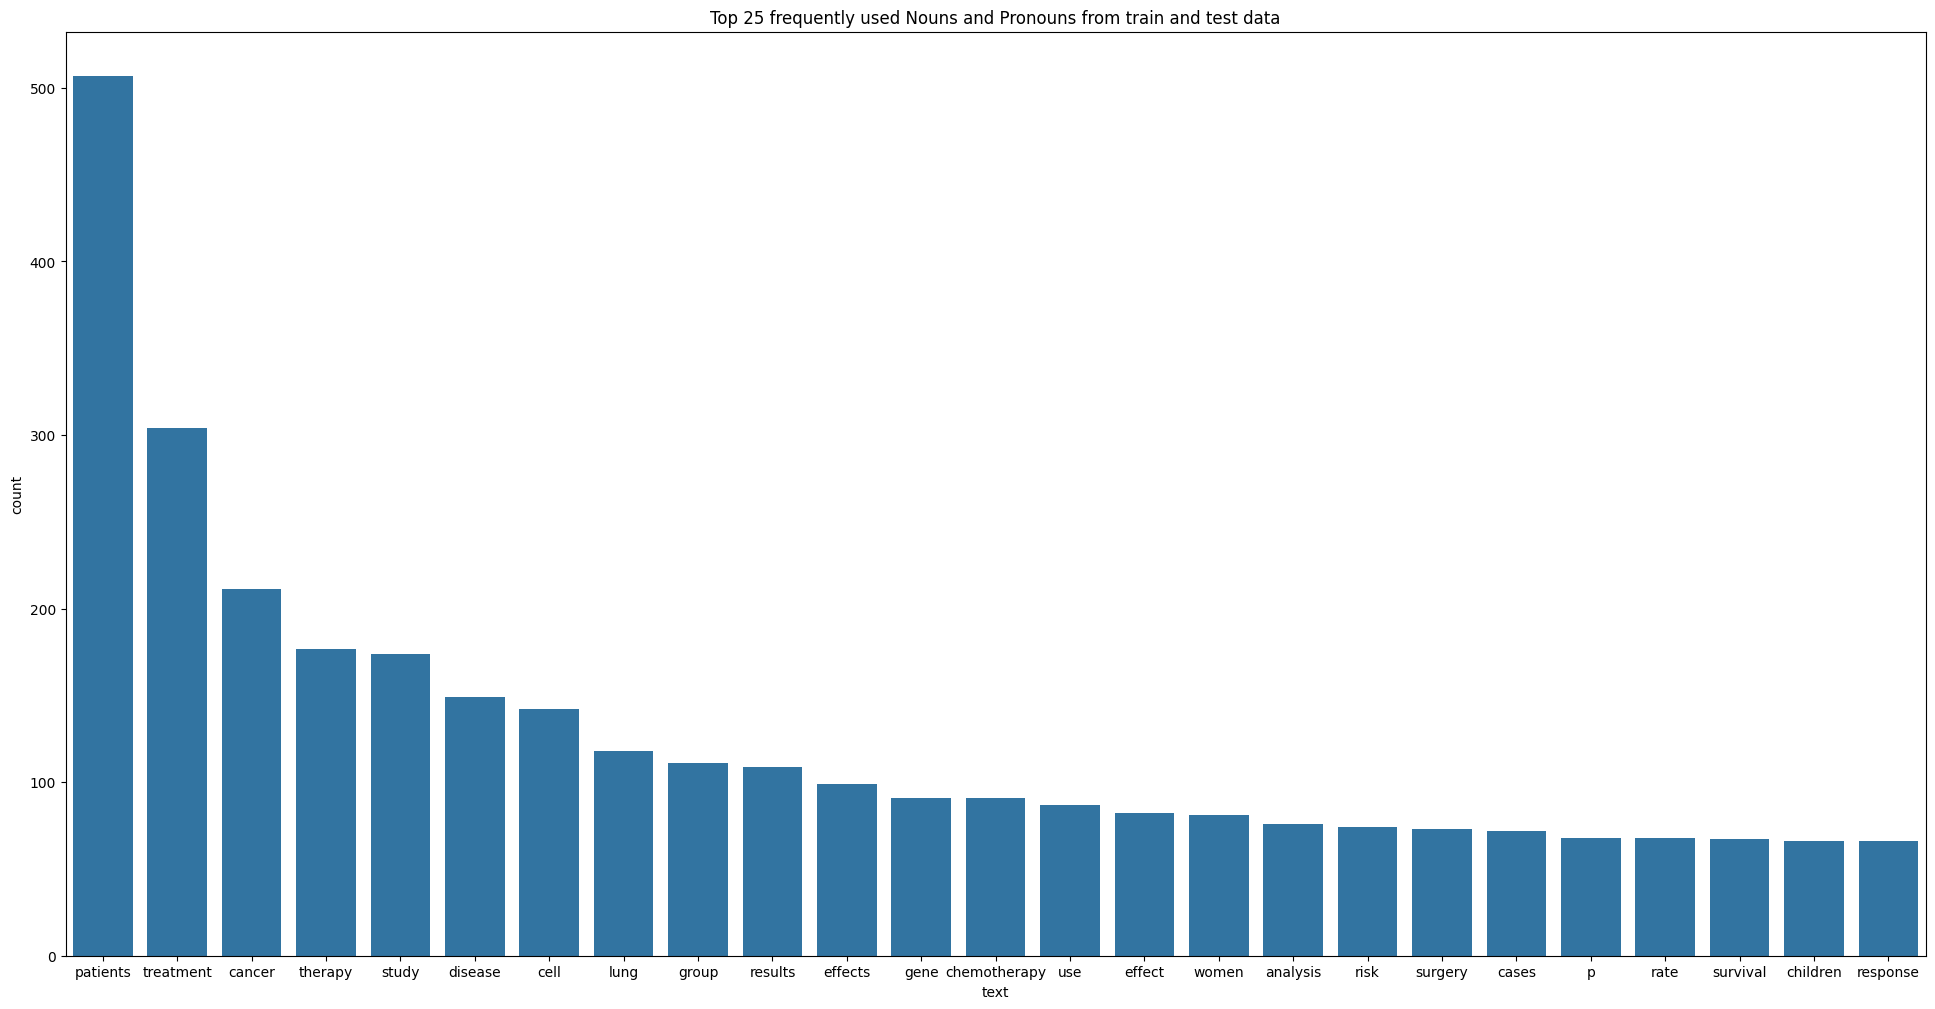

In [8]:
freq_tb=pos_all.query(f'pos_tags.isin(["NOUN","PROPN"])').text.value_counts().reset_index()
### 25 commonly used Noun or PROPN pos tags
plt.figure(figsize=(24,12))
sns.barplot(data=freq_tb.head(25),x="text",y="count",)
plt.title("Top 25 frequently used Nouns and Pronouns from train and test data")


## Defining features for CRF





In [9]:
# Let's define the features to get the feature value for one word.
def extract_feature_one_word(mod_inp,feat_inp, pos):
  tokens=model(mod_inp)
  word = feat_inp[pos]
  # print(f"The word is {word}")
 
  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word_contextual=%s' % (any(k in word.lower() for k in ["diagonisis","perscribed","given","medication","treatment","dosage","dose","treated","cured","managed","reduction of","effect of"])), # contextual features
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'words.startsWithCapital=%s' % word[0].isupper() # is the word starting with a capital letter
  ]
 
  if(pos > 0):
    prev_word = feat_inp[pos-1]
    current_word=feat_inp[pos]
    features.extend([
    'prev_word.lower=' + prev_word.lower(), 
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_word.isnoun_propn=%s' % (any(k in str(tokens[pos-1].pos_) for k in ["NOUN","PROPN"])), #prev word being NOUN or PROPN
    'current_word.isnoun_propn=%s' % (any(k in str(tokens[pos].pos_) for k in ["NOUN","PROPN"])), # current word being NOUN or PROPN
    'prev_words.startsWithCapital=%s' % prev_word[0].isupper()
  ])
  else:
    features.append('BOS') # feature to track begin of sentence 
 
  if(pos == len(feat_inp)-1):
    features.append('EOS') # feature to track end of sentence
 
  return features

## Validating the function
sent="CONTEXT : Four genetic loci have been identified as contributing to Alzheimer disease ( AD ) , including the amyloid precursor protein gene , the presenilin 1 gene , the presenilin 2 gene , and the apolipoprotein E gene , but do not account for all the genetic risk for AD"
extract_feature_one_word(mod_inp=sent,feat_inp=sent.split(),pos=25)


['word.lower=presenilin',
 'word[-3:]=lin',
 'word[-2:]=in',
 'word_contextual=False',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=False',
 'prev_word.lower=the',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.isnoun_propn=False',
 'current_word.isnoun_propn=True',
 'prev_words.startsWithCapital=False']

## Getting the features

### Write a code/function to get the features for a sentence

In [10]:
# Write a code to get features for a sentence.
def get_features_for_one_sent(sentence):
    sentence_list=sentence.split()
    return [extract_feature_one_word(mod_inp=sentence,feat_inp=sentence_list,pos=i) for i in range(len(sentence_list))]
### Validate the function
get_features_for_one_sent(sent)[:1]


[['word.lower=context',
  'word[-3:]=EXT',
  'word[-2:]=XT',
  'word_contextual=False',
  'word.isupper=True',
  'word.isdigit=False',
  'words.startsWithCapital=True',
  'BOS']]

### Write a code/function to get the labels of a sentence

In [11]:
# Write a code to get the labels for a sentence.
def get_labels_for_one_sent(labels):
    return [lbl for lbl in labels.strip().split()]
## Validating the function
get_labels_for_one_sent(train_label[2])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [12]:
X_train=[get_features_for_one_sent(sentence) for sentence in train_sentences]
X_test=[get_features_for_one_sent(sentence) for sentence in test_sentences]


### Define the labels as the target variable for test and the train dataset

In [13]:
Y_train=[get_labels_for_one_sent(labels) for labels in train_label]
Y_test=[get_labels_for_one_sent(labels) for labels in test_label]


## Build the CRF Model

In [14]:
# Build the CRF model.
crf_model=CRF(max_iterations=1000)
crf_model.fit(X_train,Y_train)

CRF(max_iterations=1000)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [15]:
y_train_pred=crf_model.predict(X_train)
y_test_pred=crf_model.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [16]:
print(f"Train accuracy: {metrics.flat_f1_score(Y_train,y_train_pred,average="weighted")*100:.2f}%")
print(f"Test accuracy: {metrics.flat_f1_score(Y_test,y_test_pred,average="weighted")*100:.2f}%")

Train accuracy: 94.00%
Test accuracy: 90.62%


## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



In [17]:
### Create a dictionary 
test_df_extracted["Predicted_labels"]=y_test_pred
display(test_df_extracted.head())


,test_Sentence,test_label,len_sent,len_label,Predicted_labels
0,"Furthermore , when all deliveries were analyz...",O O O O O O O O O O O O O O O O O O O O O O O...,44,44,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"As the ambient temperature increases , there ...",O O O O O O O O O O O O O O O O O O O,19,19,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,The daily high temperature ranged from 71 to ...,O O O O O O O O O O O O O O O O O O O O O O O O,24,24,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,There was a significant correlation between t...,O O O O O O O O O O O O O O O O O O O O O O O...,38,38,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,Fluctuations in ambient temperature are inver...,O O O O O O O O O O O,11,11,"[O, O, O, O, O, O, O, O, O, O, O]"


### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

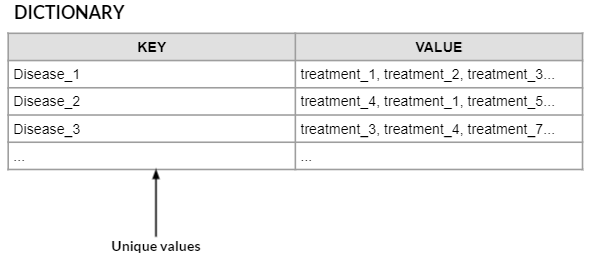

In [63]:
disease_list=[]
treatment_list=[]
med_dict={}

for idx in range(len(test_sentences)):
    sent_list=test_sentences[idx].split()
    label_list=y_test_pred[idx]
    disease=''
    treatment=''
    # print(len(label_list),len(sent_list))
    for i in range(len(label_list)):
        if label_list[i]=="D" or label_list[i]=="T" :
            disease += ' '+ sent_list[i] if label_list[i]=="D" else ''
            treatment += ' '+ sent_list[i] if label_list[i]=="T" else ''
        # elif label_list[i]=="T":
        #     treatment += ' '+ sent_list[i]
        else:
            continue
    med_dict.update({disease.strip():treatment.strip()})
med_df=pd.DataFrame({'disease':med_dict.keys(),'treatment':med_dict.values()})
display(med_df[50:55])
med_dict['malignant pleural mesothelioma']

,disease,treatment
50,severe acquired hyperammonemia cancer,organ transplantation and chemotherapy
51,major pulmonary embolism,
52,congestive heart failure ( P=.013 ) chronic pu...,
53,malignant pleural mesothelioma,"thoracotomy , radiotherapy , and chemotherapy"
54,Additional edema,


'thoracotomy , radiotherapy , and chemotherapy'

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [60]:
print(f'Treatment for the disease Hereditary Retinoblastoma: \033[1m{med_dict['hereditary retinoblastoma'].capitalize()}\033[2m')

Treatment for the disease Hereditary Retinoblastoma: Radiotherapy
